# Day 22: Mode Maze

## Part 1

The two function `geoidx` and `erosion` implement a level of cross-recursion that can become very deep, better implement some memoization!

In [1]:
import numpy as np
from collections import defaultdict

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)

def geoidx(x,y,depth,xt=10,yt=10):
    if G[(x,y)]!= -1:
        return G[(x,y)]
    g = -1
    if x==xt and y==yt:
        g = 0
        G[(x,y)] = g
        return g
    if y==0:
        g = x*16807
        G[(x,y)] = g
        return g
    if x==0:
        g = y*48271
        G[(x,y)] = g
        return g
    else:
        g = erosion(x-1,y,depth,xt,yt)*erosion(x,y-1,depth,xt,yt)
        G[(x,y)] = g
        return g

def erosion(x,y,depth,xt=10,yt=10):
    if E[(x,y)]!= -1:
        return E[(x,y)] 
    e = ( geoidx(x,y,depth,xt,yt) + depth )%20183
    E[(x,y)] = e
    return e

def exploreCave(depth=510,xt=10,yt=10):
    cave = np.zeros((yt+1,xt+1),dtype=int)
    for y in range(yt+1):
        for x in range(xt+1):
            e = erosion(x,y,depth,xt,yt)
            t = e % 3
            #print(x,y,e,t)
            cave[y][x] = t
    return cave

Risk level = 114


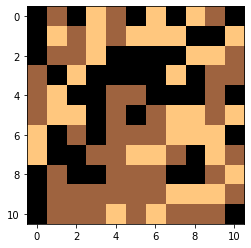

In [19]:
# Re-initialize cache dictionaries to avoid contamination between example and full input

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
    
cave = exploreCave(depth=510,xt=10,yt=10)

import matplotlib.pyplot as plt
plt.imshow(cave,cmap="copper")
print("Risk level =",sum(sum(cave)))

Risk level = 8575


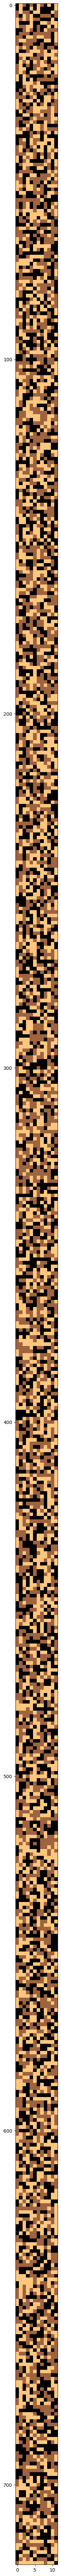

In [20]:
depth = 10689
xt = 11
yt = 722

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)

cave = exploreCave(depth,xt,yt)

plt.figure(figsize=(10,100),dpi=100)
plt.imshow(cave,cmap="copper")
print("Risk level =",sum(sum(cave)))

## Part 2

This could be solved with BFS tracking all possible path of (positions on grid, equipement status) pairs, where possible next steps depend on adjacent cave values and previous equipemnt status.